# 100 Way Classification Experiment

In [17]:

# set up the environment and install any missing packages:
!pip install torch torchvision numpy scipy matplotlib pandas pillow tqdm MLclf

# PyTorch for building and training neural networks
import torch
from torch import nn, utils
import torch.nn.functional as F

# Torchvision for datasets and transformations
from torchvision import models, datasets, transforms
from torchvision.models import resnet50

# DataLoader for creating training and validation dataloaders

from torch.utils.data import DataLoader

# Random for random number generation
import random

# Numpy for numerical operations
import numpy as np

# Matplotlib for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

# Pandas for data manipulation
import pandas as pd

# PIL for image processing
from PIL import Image

# TQDM for progress bars
from tqdm import tqdm

# OS for operating system operations
import os

# Collections for ordered dictionaries
from collections import OrderedDict

# Torchmeta for meta-learning modules
from torchmeta.modules import MetaModule, MetaSequential

# Regular expressions
import re

# Custom MLclf module (imports miniimagent dataset)
from MLclf import MLclf

# Deepcopy for copying models
from copy import deepcopy

In [12]:
class ResNet50(nn.Module):
    def __init__(self, pretrained=True, device="cuda"):
        super().__init__()

        # Load pretrained ResNet-50
        resnet = resnet50(pretrained=pretrained)
        # Remove the fully connected layer and retain only the convolutional backbone
        self.feature_extractor = nn.Sequential(
            *(list(resnet.children())[:-2])  # Removes FC and avg pooling
        )
        
        # Add adaptive average pooling to reduce feature maps to 1x1
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Set the number of output features (512 for ResNet-50)
        self.num_features = resnet.fc.in_features

        self.device = device
        self.to(device)

    def forward(self, x):
        # Pass through ResNet backbone
        x = self.feature_extractor(x)
        
        # Global average pooling to get feature vector
        x = self.pool(x)
        x = x.view(x.size(0), -1)

        return x
    
    def get_optimizer_list(self):
        # Add a lower learning rate for the pretrained parameters
        return [{'params': self.feature_extractor.parameters(), 'lr': 1e-4}]

In [18]:
class ClassificationHead(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(ClassificationHead, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims + [output_dim]
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims) - 2:
                layers.append(nn.ReLU(inplace=True))
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.mlp(x)


In [14]:
class CIFAR100Classifier(nn.Module):
    def __init__(self, backbone, head):
        super(CIFAR100Classifier, self).__init__()
        self.backbone = backbone
        self.head = head
    
    def forward(self, x):
        features = self.backbone(x)
        return self.head(features)


In [15]:
## Loading the data Cifar100

# Download CIFAR-100 dataset
cifar100 = datasets.CIFAR100(root='data/', train=True, download=True)
cifar100.name, cifar100.num_classes = 'CIFAR-100', 100

Files already downloaded and verified


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10
Train Loss: 3.8009, Train Acc: 0.0844
Val Loss: 3.2583, Val Acc: 0.1650


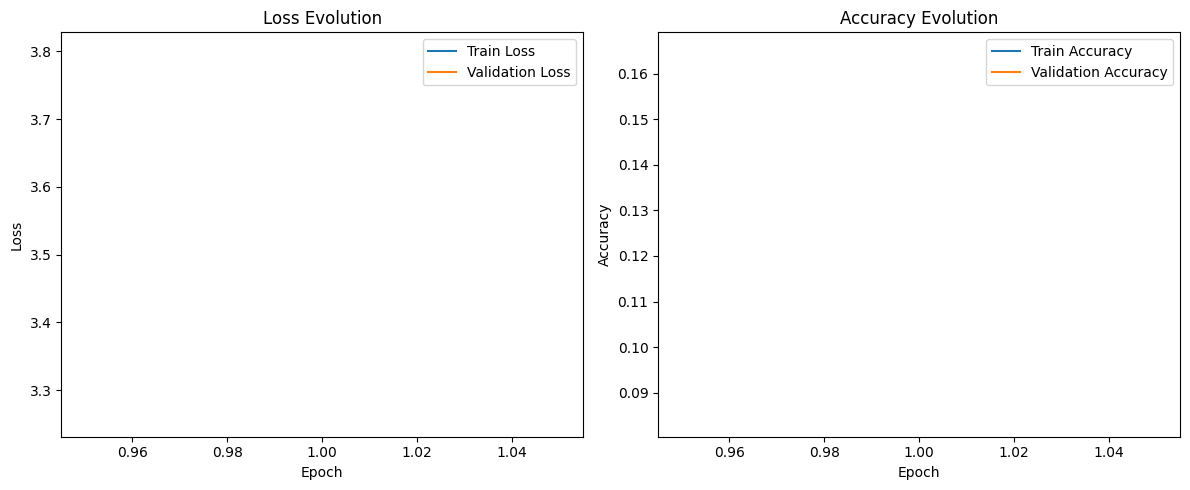

Epoch 2/10
Train Loss: 3.0168, Train Acc: 0.2112
Val Loss: 2.7650, Val Acc: 0.2696


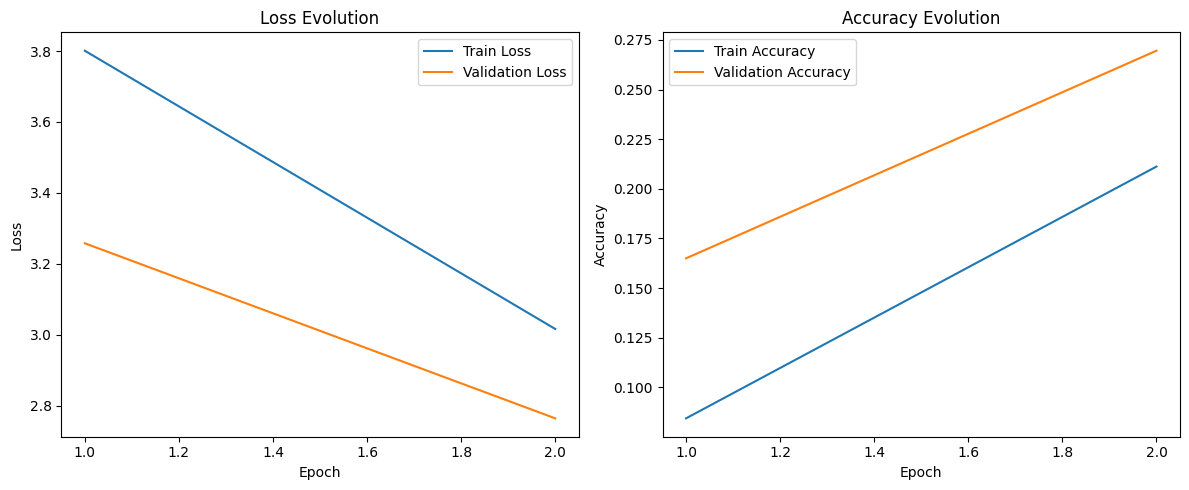

Epoch 3/10
Train Loss: 2.6391, Train Acc: 0.2949
Val Loss: 2.5095, Val Acc: 0.3208


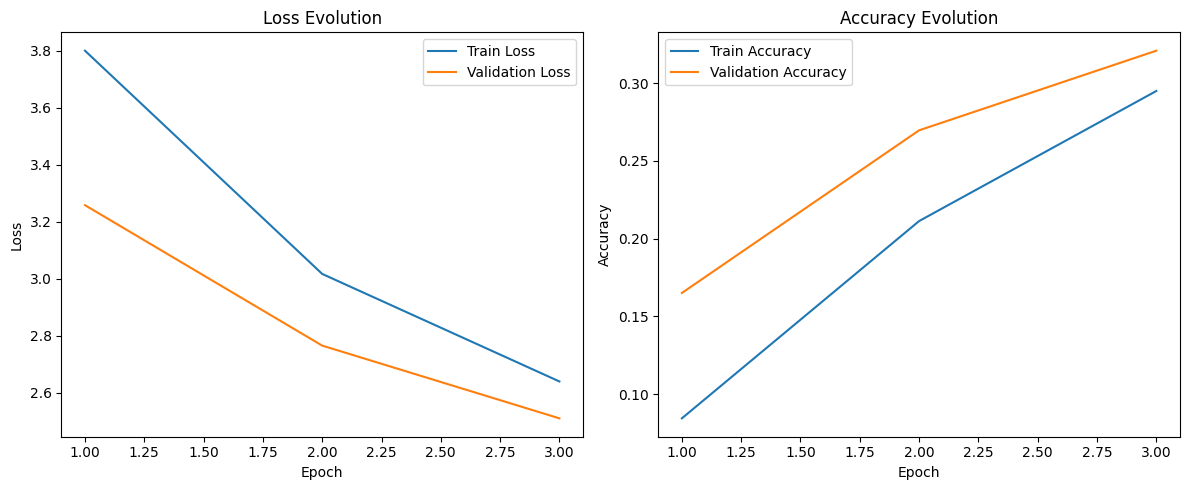

Epoch 4/10
Train Loss: 2.4368, Train Acc: 0.3456
Val Loss: 2.4002, Val Acc: 0.3650


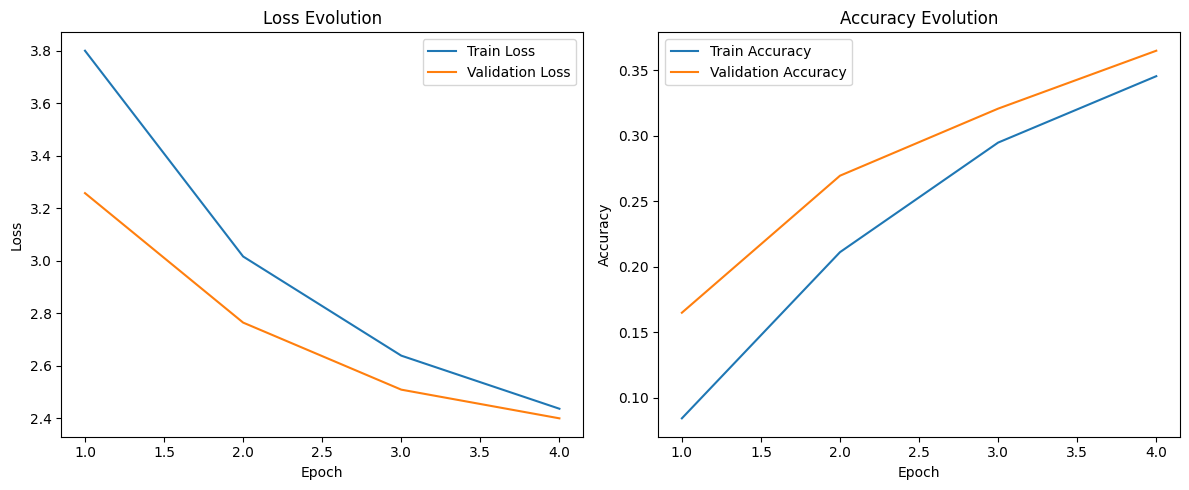

Epoch 5/10
Train Loss: 2.2128, Train Acc: 0.3963
Val Loss: 2.2993, Val Acc: 0.3927


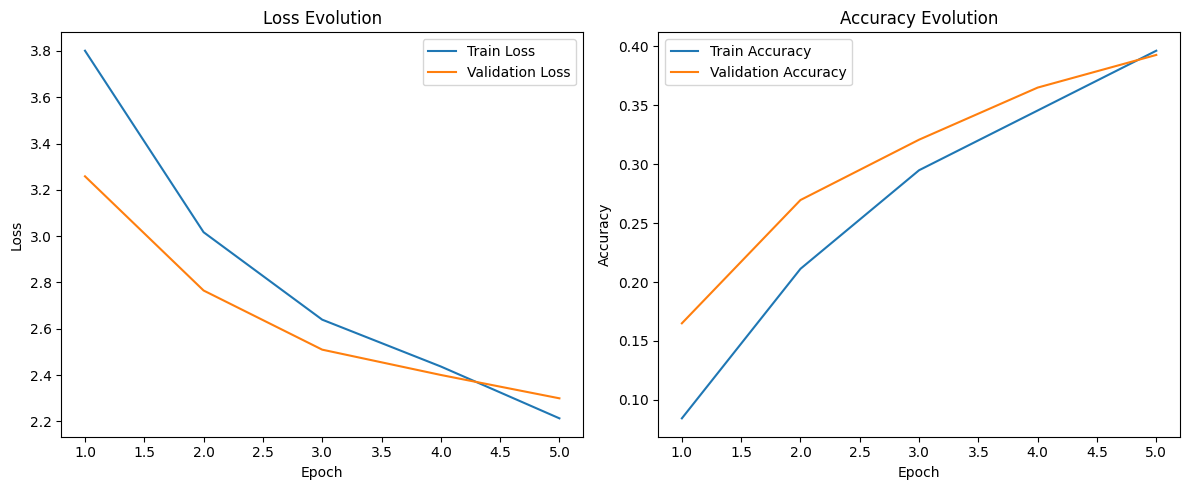

Epoch 6/10
Train Loss: 2.1180, Train Acc: 0.4183
Val Loss: 2.3667, Val Acc: 0.3787


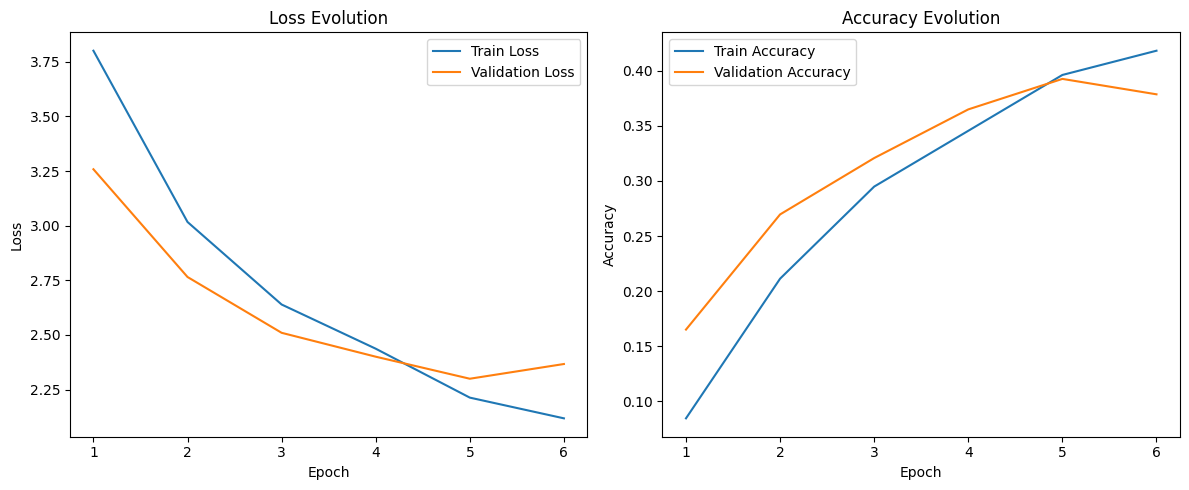

Epoch 7/10
Train Loss: 2.1589, Train Acc: 0.4156
Val Loss: 3.1980, Val Acc: 0.2492


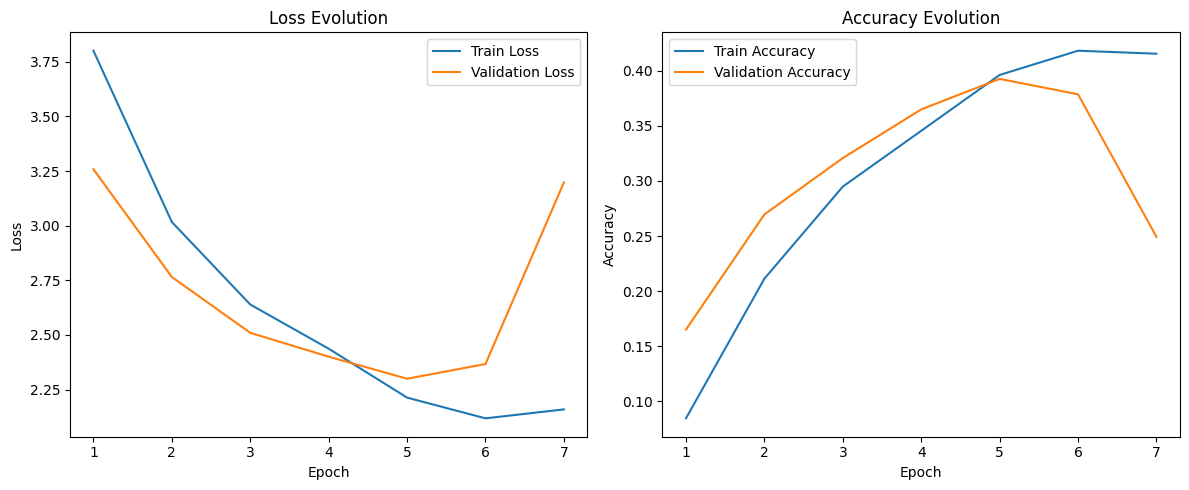

Epoch 8/10
Train Loss: 2.5188, Train Acc: 0.3469
Val Loss: 2.4278, Val Acc: 0.3734


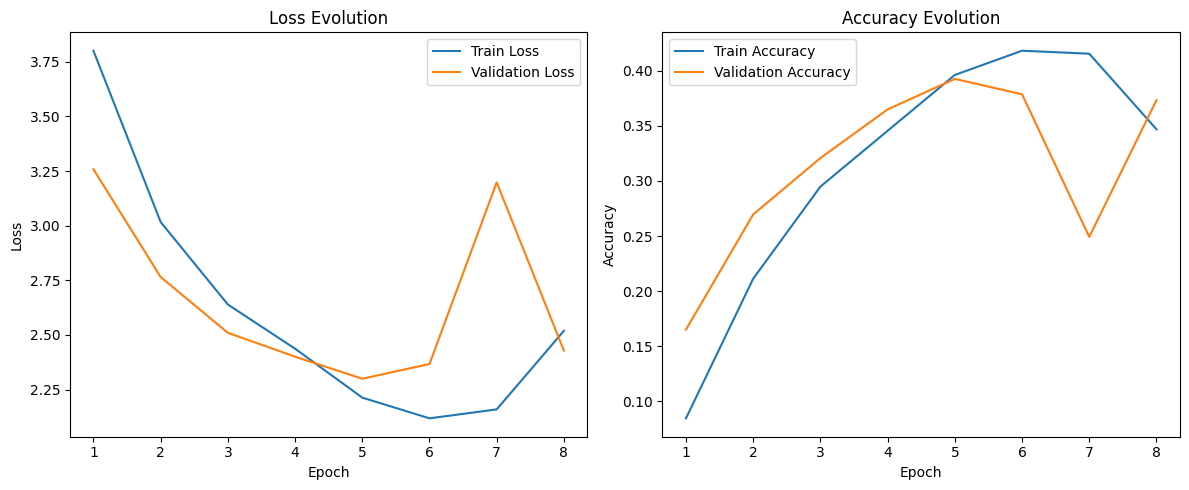

Epoch 9/10
Train Loss: 2.0473, Train Acc: 0.4403
Val Loss: 2.1269, Val Acc: 0.4339


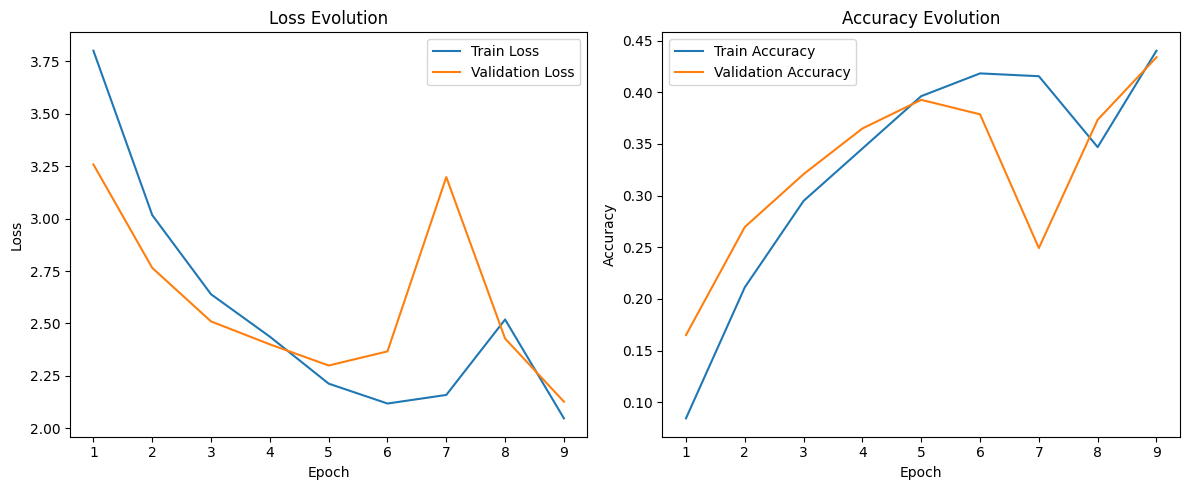

Epoch 10/10
Train Loss: 1.7601, Train Acc: 0.5029
Val Loss: 2.1081, Val Acc: 0.4459


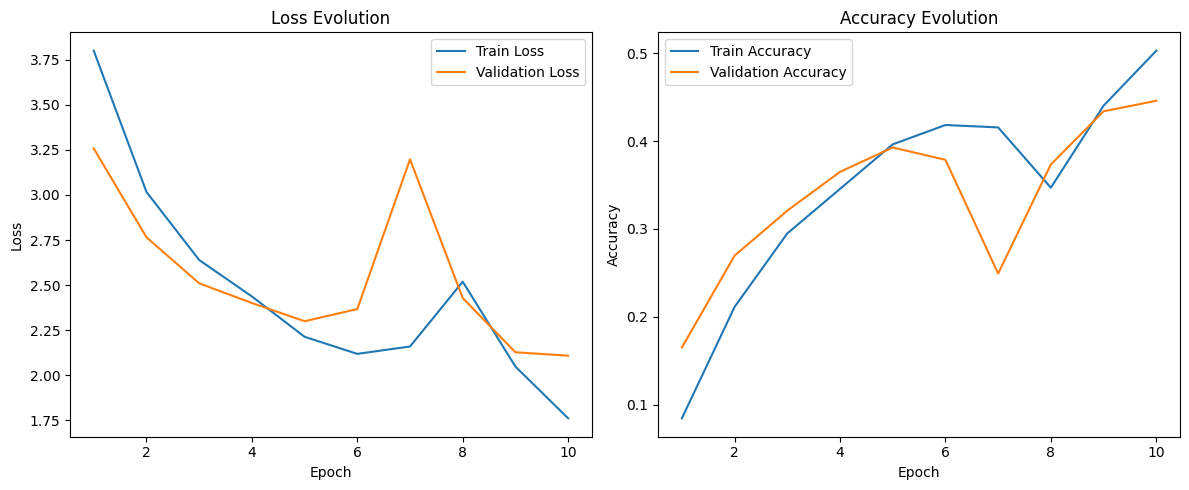

In [20]:
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize

# Data loading
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
train_dataset = datasets.CIFAR100(root='data/', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root='data/', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Model, loss, and optimizer
backbone = ResNet50(pretrained=True)
head = ClassificationHead(input_dim=2048, hidden_dims=[512, 256], output_dim=100)
model = CIFAR100Classifier(backbone, head).to("cuda")

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Training loop
def train_one_epoch(model, loader, optimizer, criterion, device="cuda"):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return running_loss / total, correct / total

# Evaluation loop
def evaluate(model, loader, criterion, device="cuda"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return running_loss / total, correct / total

# Initialize lists to track loss and accuracy
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training and validation loop with tracking
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    # Append metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Plot the loss and accuracy evolution
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 2), train_losses, label="Train Loss")
    plt.plot(range(1, epoch + 2), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Evolution")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 2), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, epoch + 2), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Evolution")
    plt.legend()

    plt.tight_layout()
    plt.show()
    


In [21]:
torch.save(model.state_dict(), "checkpoints/cifar100_classifier.pth")

# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


Test Loss: 2.1081, Test Acc: 0.4459


Epoch 1/10 (Frozen Backbone)
Train Loss: 1.4716, Train Acc: 0.5718
Val Loss: 2.1306, Val Acc: 0.4626


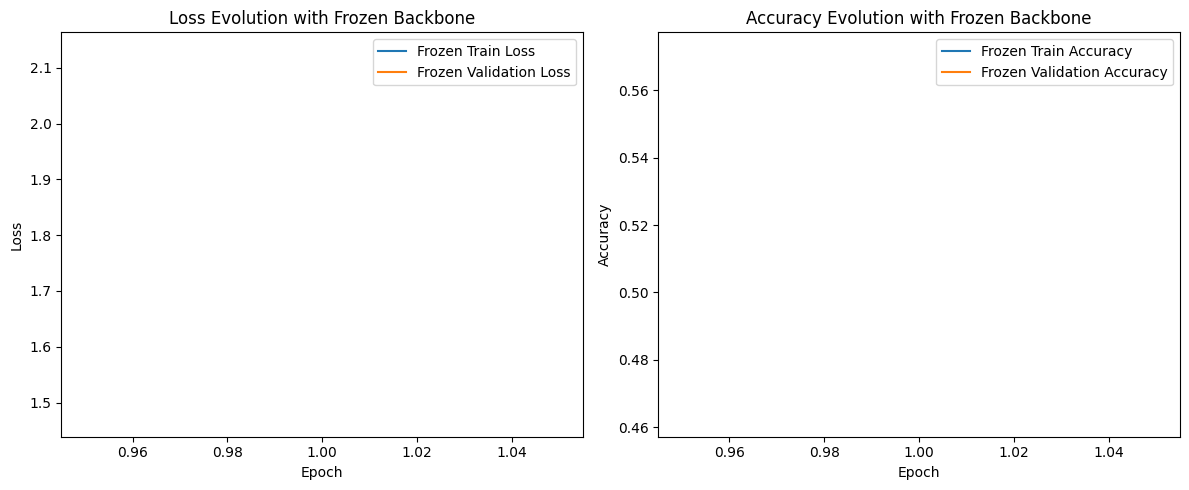

Epoch 2/10 (Frozen Backbone)
Train Loss: 1.4163, Train Acc: 0.5856
Val Loss: 2.0939, Val Acc: 0.4684


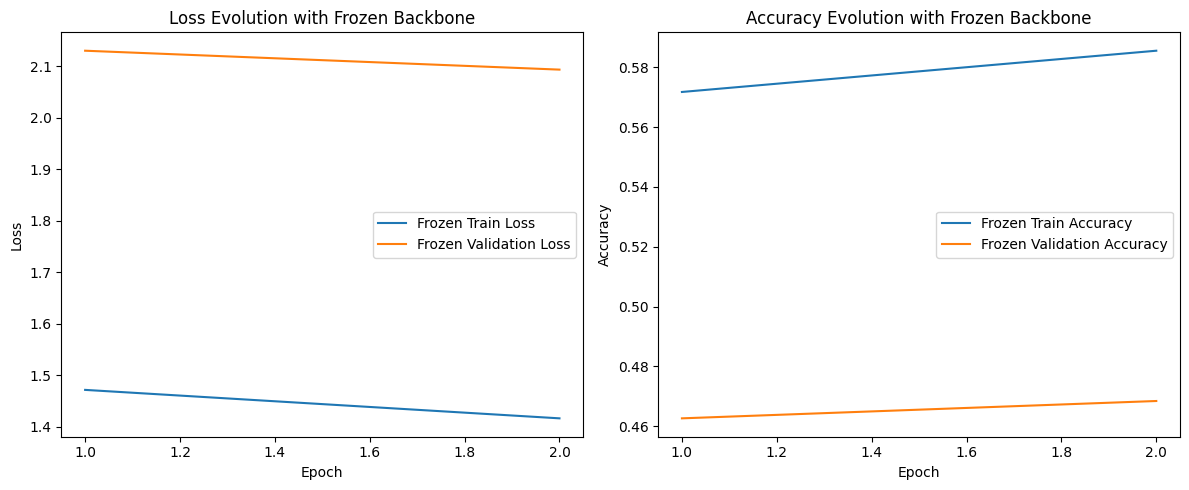

Epoch 3/10 (Frozen Backbone)
Train Loss: 1.3914, Train Acc: 0.5913
Val Loss: 2.0955, Val Acc: 0.4675


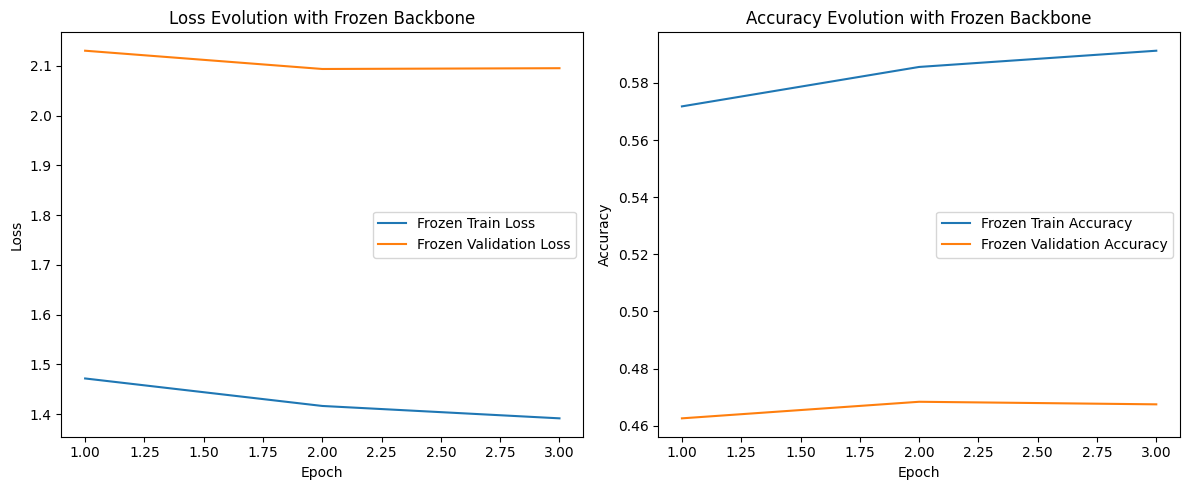

Epoch 4/10 (Frozen Backbone)
Train Loss: 1.3740, Train Acc: 0.5932
Val Loss: 2.0956, Val Acc: 0.4691


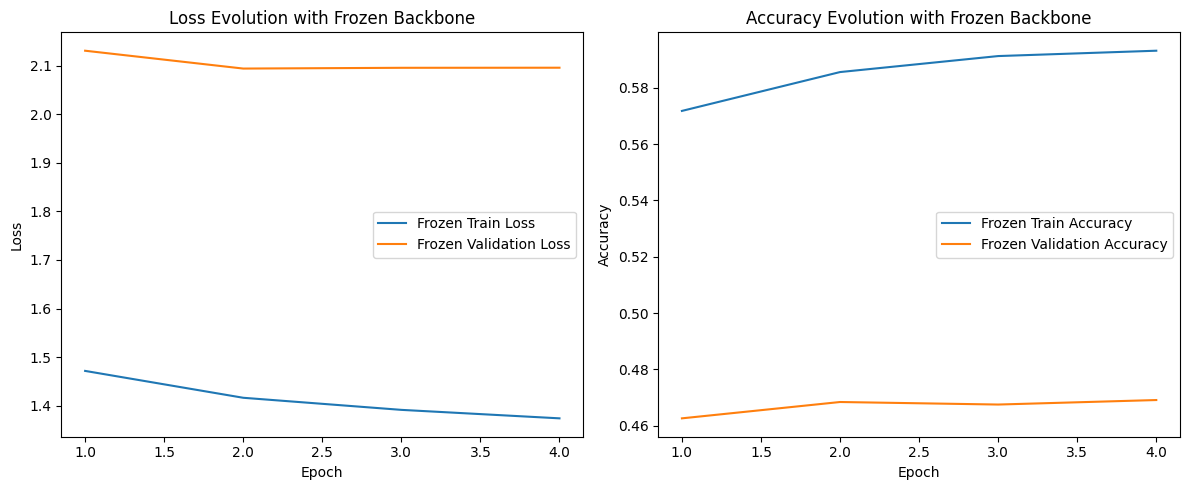

Epoch 5/10 (Frozen Backbone)
Train Loss: 1.3508, Train Acc: 0.6007
Val Loss: 2.1199, Val Acc: 0.4706


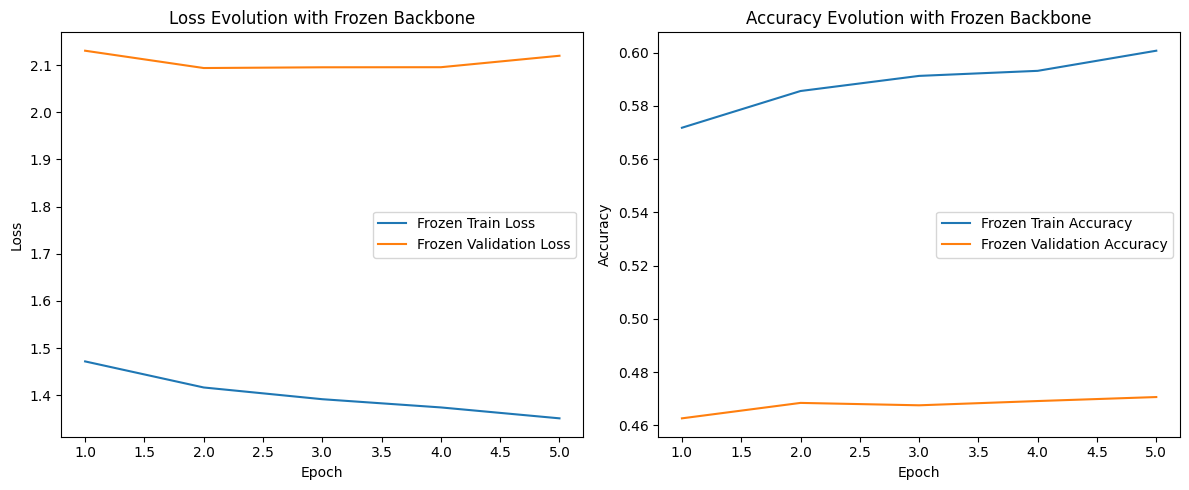

Epoch 6/10 (Frozen Backbone)
Train Loss: 1.3378, Train Acc: 0.6010
Val Loss: 2.1289, Val Acc: 0.4711


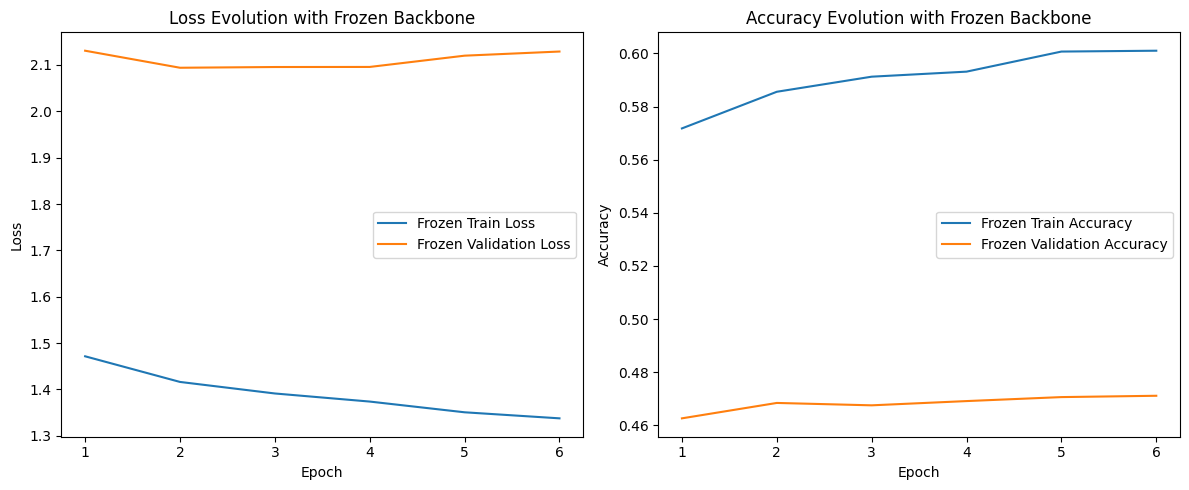

Epoch 7/10 (Frozen Backbone)
Train Loss: 1.3237, Train Acc: 0.6054
Val Loss: 2.1284, Val Acc: 0.4743


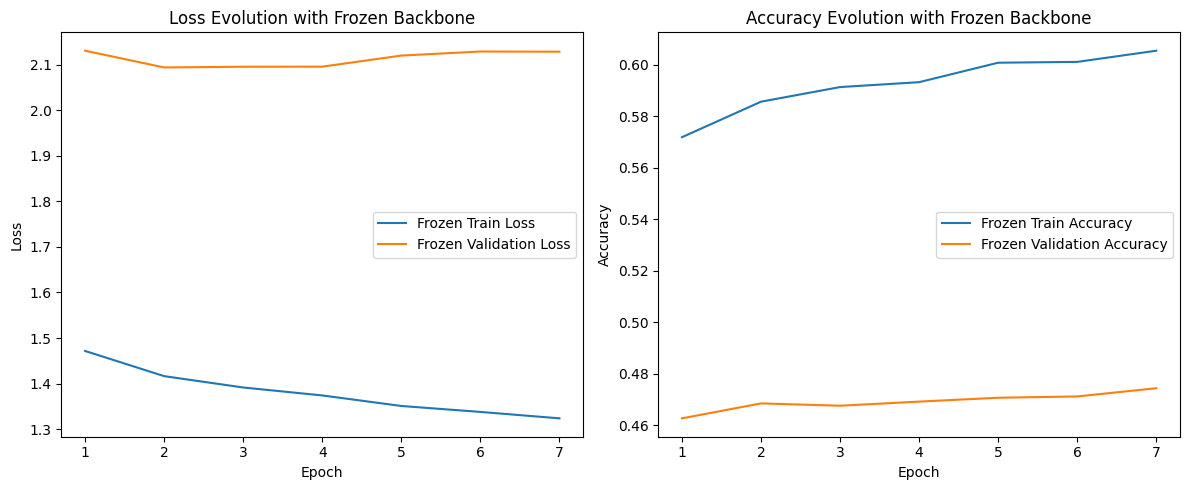

Epoch 8/10 (Frozen Backbone)
Train Loss: 1.2971, Train Acc: 0.6117
Val Loss: 2.1602, Val Acc: 0.4673


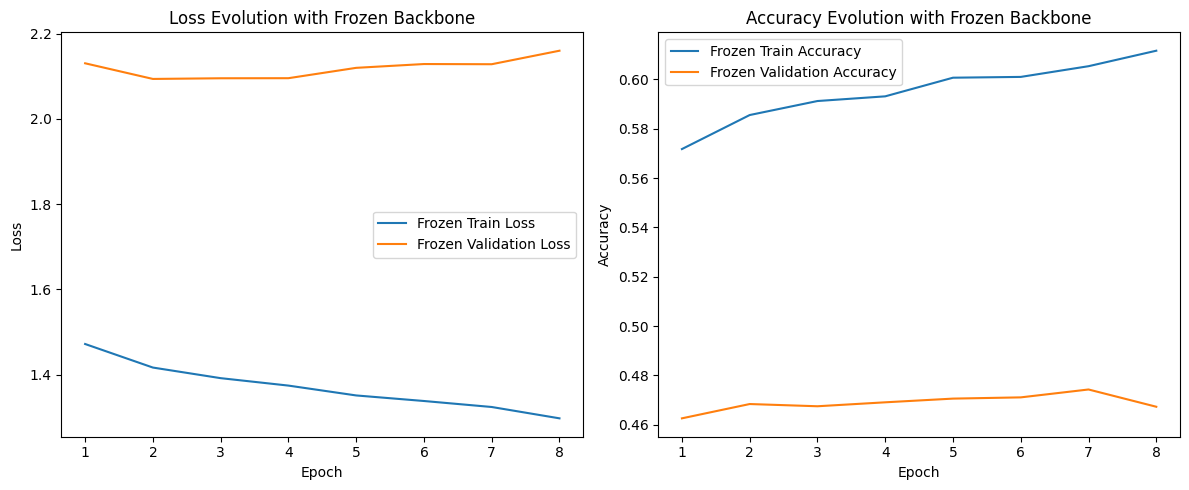

Epoch 9/10 (Frozen Backbone)
Train Loss: 1.2899, Train Acc: 0.6156
Val Loss: 2.1818, Val Acc: 0.4723


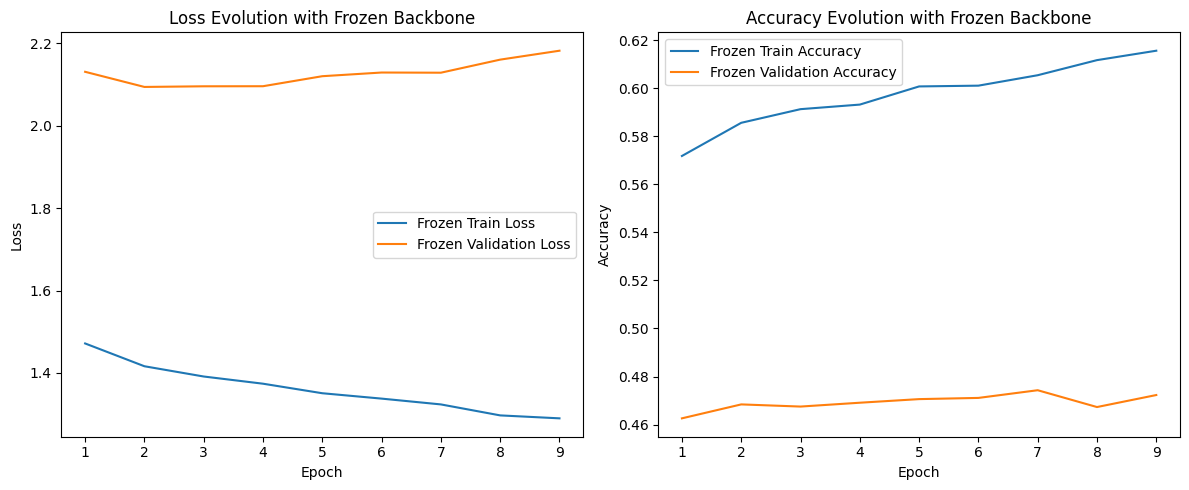

Epoch 10/10 (Frozen Backbone)
Train Loss: 1.2694, Train Acc: 0.6198
Val Loss: 2.1457, Val Acc: 0.4702


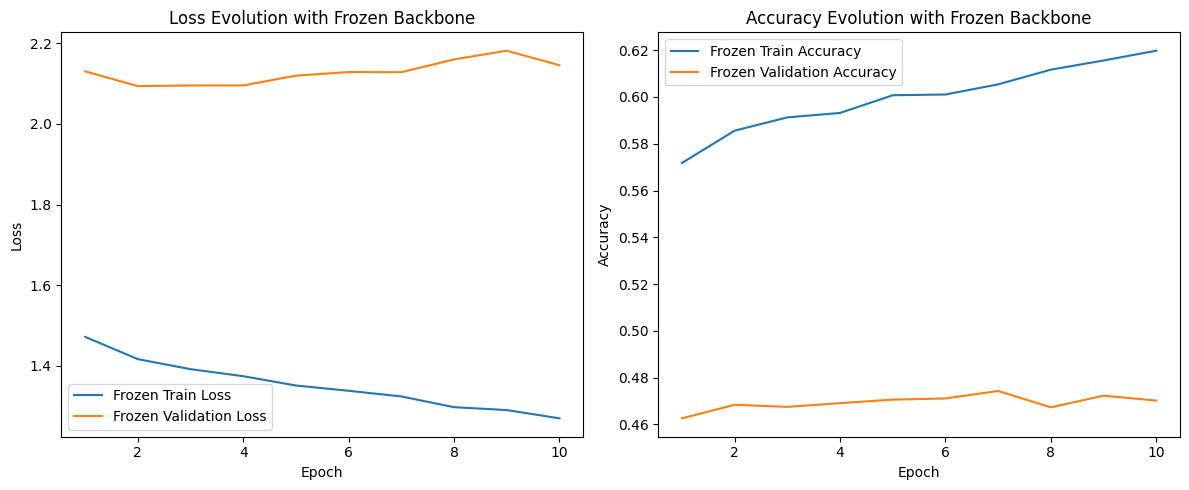

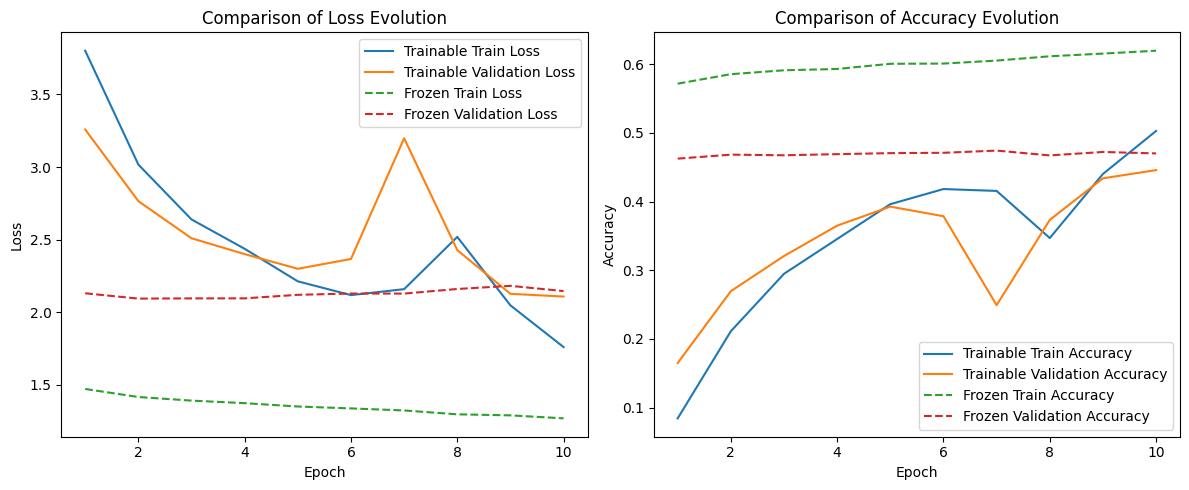

In [23]:
# Train with the backbone frozen


# Freeze the backbone
for param in backbone.parameters():
    param.requires_grad = False

# Create a new model with the frozen backbone
frozen_model = CIFAR100Classifier(backbone, head).to("cuda")

# Define a new optimizer (only for the classification head)
frozen_optimizer = Adam(frozen_model.head.parameters(), lr=0.001)

# Re-initialize metrics tracking for the frozen model
frozen_train_losses, frozen_val_losses = [], []
frozen_train_accuracies, frozen_val_accuracies = [], []

# Training and validation loop for the frozen model
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(frozen_model, train_loader, frozen_optimizer, criterion)
    val_loss, val_acc = evaluate(frozen_model, test_loader, criterion)

    # Append metrics for plotting
    frozen_train_losses.append(train_loss)
    frozen_val_losses.append(val_loss)
    frozen_train_accuracies.append(train_acc)
    frozen_val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} (Frozen Backbone)")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Plot the loss and accuracy evolution
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 2), frozen_train_losses, label="Frozen Train Loss")
    plt.plot(range(1, epoch + 2), frozen_val_losses, label="Frozen Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Evolution with Frozen Backbone")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 2), frozen_train_accuracies, label="Frozen Train Accuracy")
    plt.plot(range(1, epoch + 2), frozen_val_accuracies, label="Frozen Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Evolution with Frozen Backbone")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Comparison plots
plt.figure(figsize=(12, 5))

# Compare loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Trainable Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Trainable Validation Loss")
plt.plot(range(1, num_epochs + 1), frozen_train_losses, label="Frozen Train Loss", linestyle="--")
plt.plot(range(1, num_epochs + 1), frozen_val_losses, label="Frozen Validation Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Comparison of Loss Evolution")
plt.legend()

# Compare accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Trainable Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Trainable Validation Accuracy")
plt.plot(range(1, num_epochs + 1), frozen_train_accuracies, label="Frozen Train Accuracy", linestyle="--")
plt.plot(range(1, num_epochs + 1), frozen_val_accuracies, label="Frozen Validation Accuracy", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Comparison of Accuracy Evolution")
plt.legend()

plt.tight_layout()
plt.show()


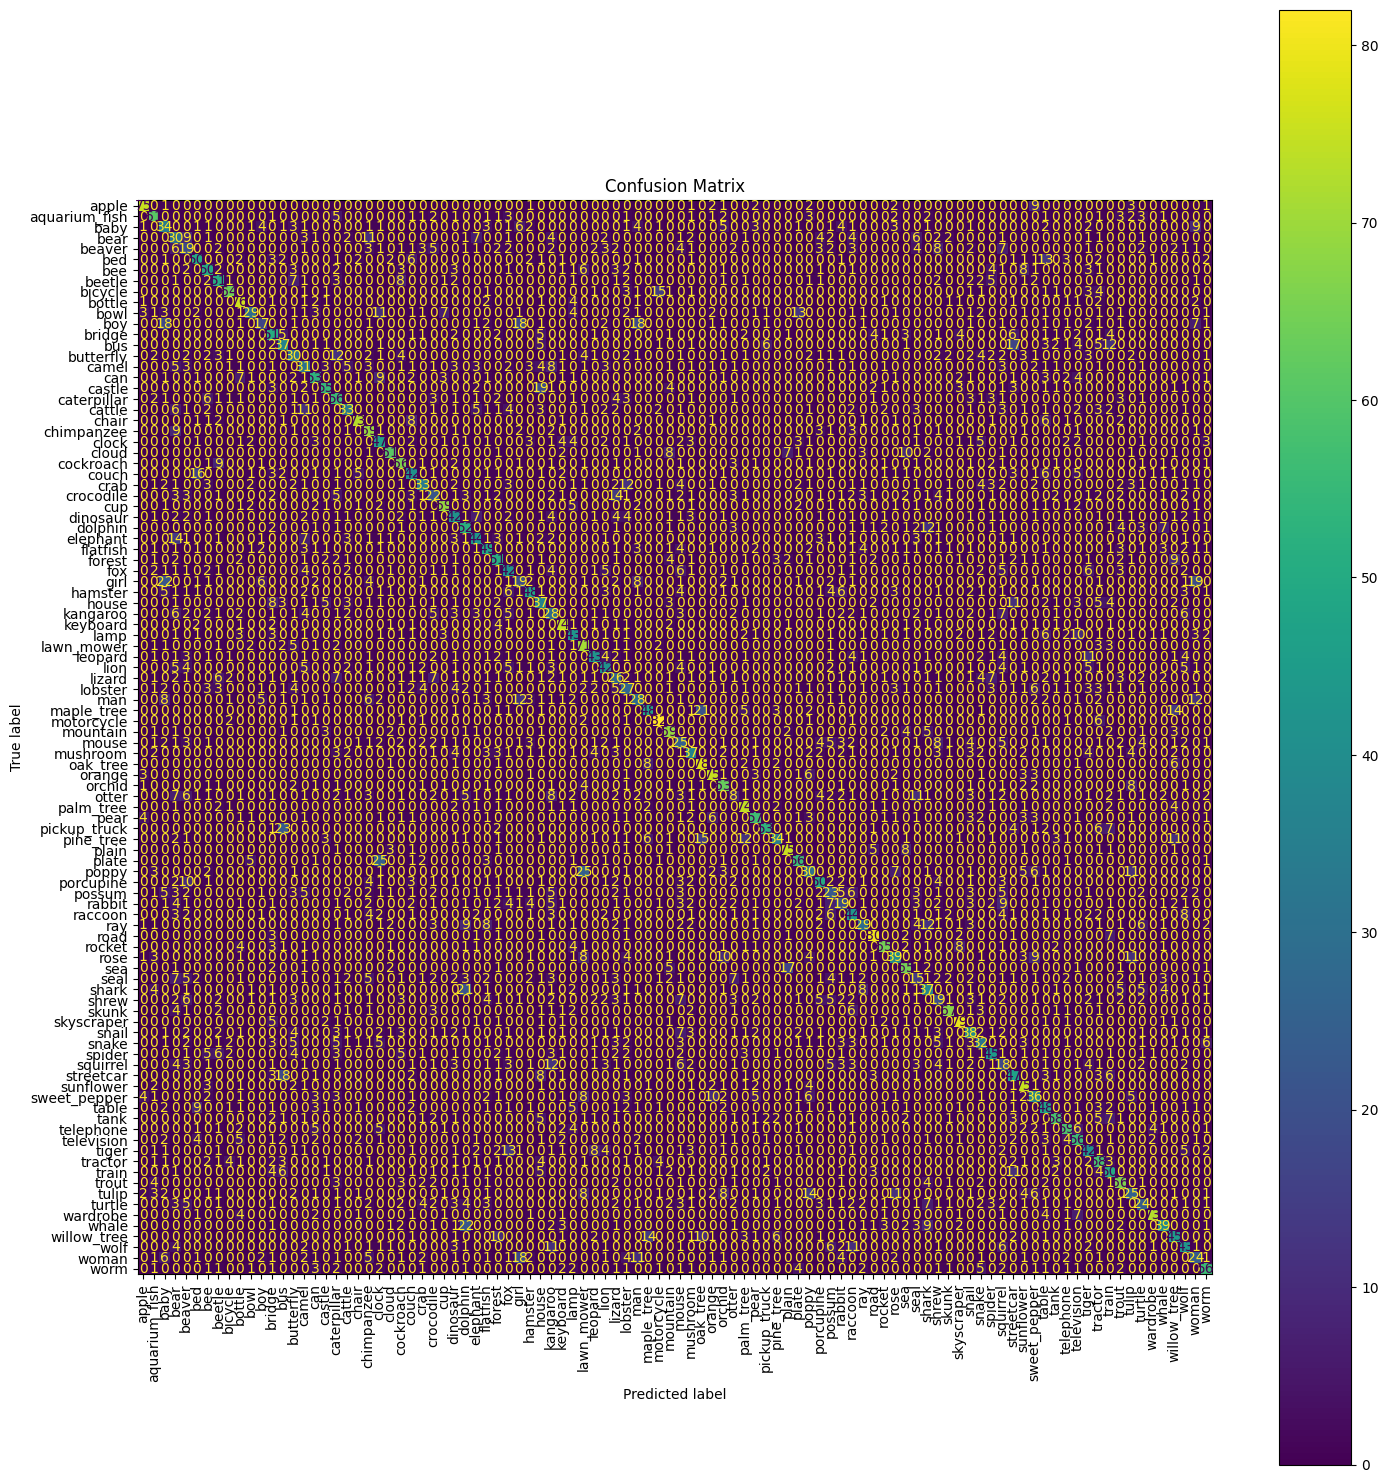

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def evaluate_with_confusion_matrix(model, loader, classes, device="cuda"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(15, 15))  # Set the figure size
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='viridis', xticks_rotation='vertical', ax=ax)
    plt.title("Confusion Matrix")
    plt.tight_layout()  # Adjust layout for better fit
    plt.show()

cifar_classes = cifar100.classes

# Evaluate the trained model with the confusion matrix
evaluate_with_confusion_matrix(model, test_loader, cifar_classes)

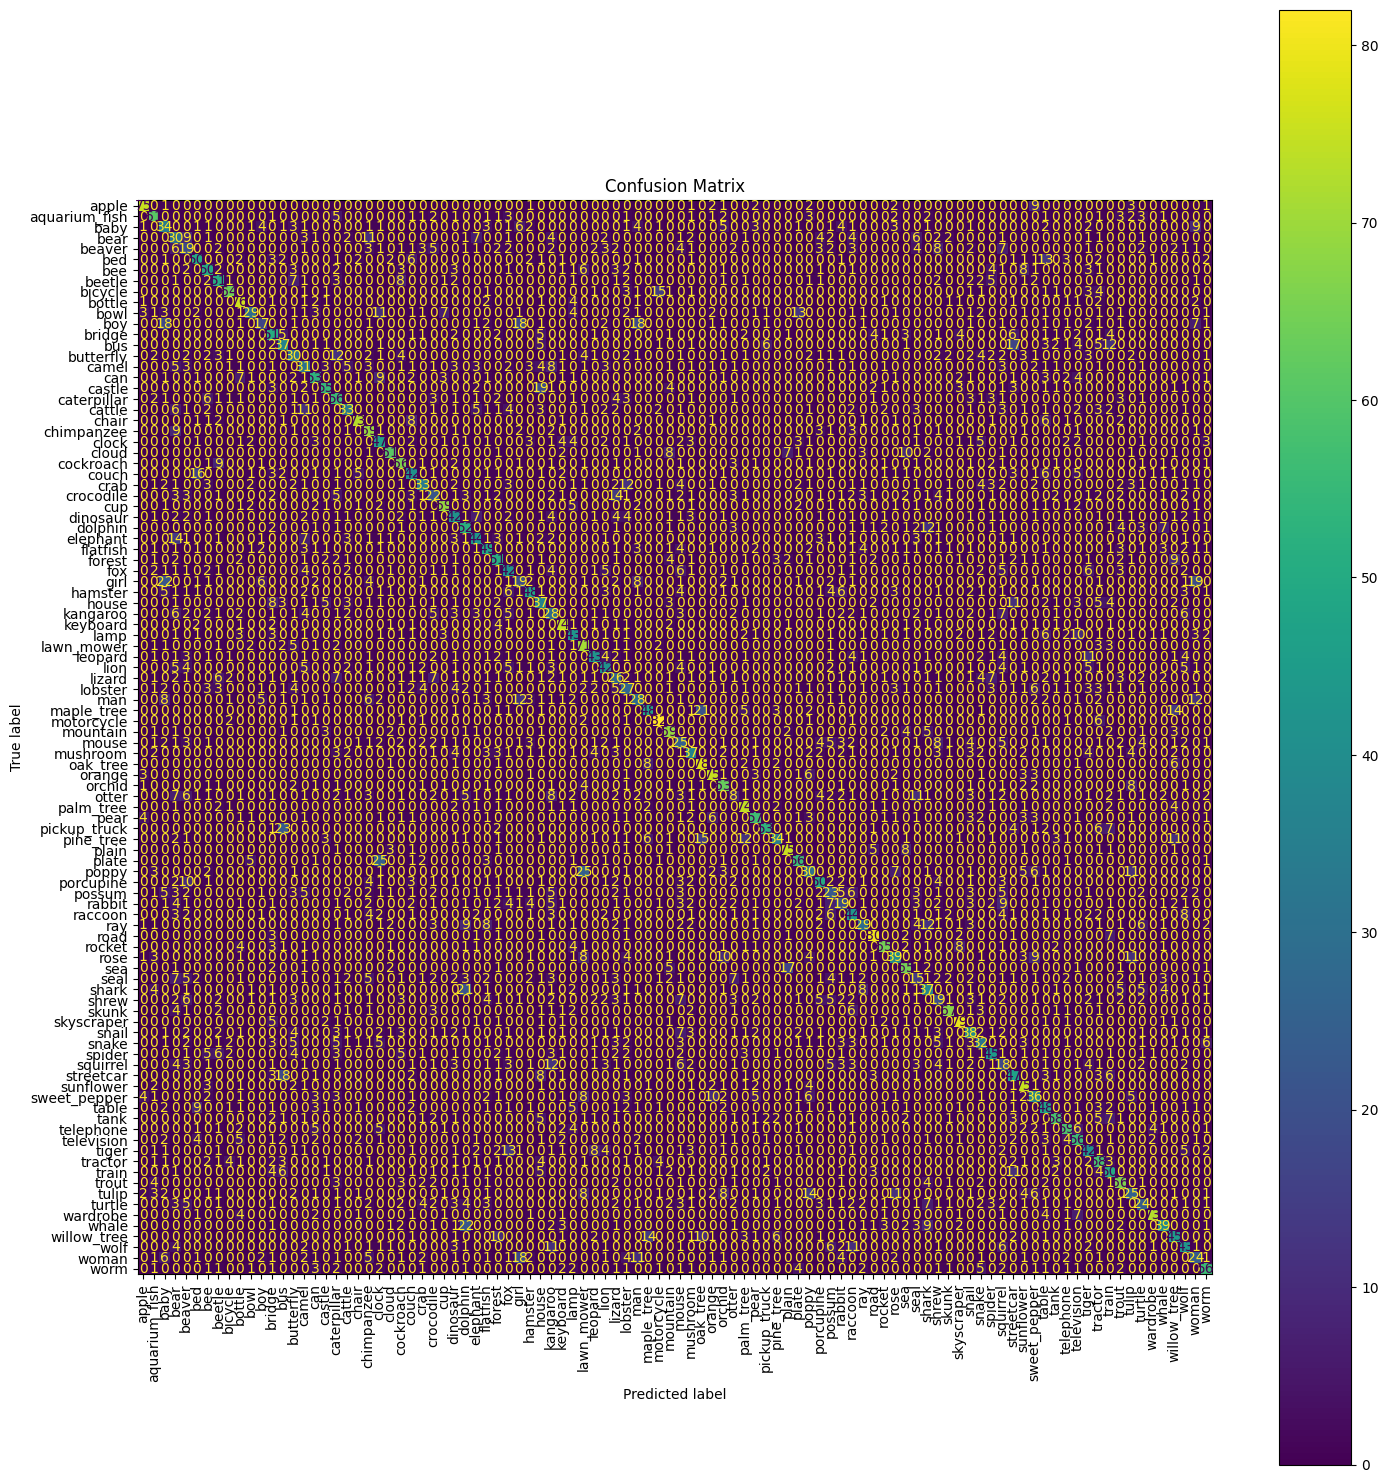

In [26]:
# Evaluate the frozen model with the confusion matrix
evaluate_with_confusion_matrix(frozen_model, test_loader, cifar_classes)
